In [1]:
from smallworld.draw import draw_network
from smallworld import get_smallworld_graph
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import EoN
import random
from collections import defaultdict
from collections import Counter

# Function for discrete SIR model

In [2]:
def _simple_test_transmission_(u, v, beta): 
    return random.random()<beta

def _simple_test_quarantine_(u, p0, p1): ## infected individual quarantines themselves w.p. p0*p1
    return random.random()<(p0*p1)

def _simple_test_quarantine_neighbors_(u, p1): ## neighbors of infected individual each quarantine themselves w.p. p1
    return random.random()<(p1)

def _simple_test_detection_(u, p0): ## infective vertex is detected, so that their neighbors are vaccinated
    return random.random()<(p0)

In [3]:
def discrete_SIR(G, test_transmission = _simple_test_transmission_, test_quarantine = _simple_test_quarantine_, 
                 test_quarantine_neighbors = _simple_test_quarantine_neighbors_, beta = 0.319, p0 = 0.26, p1 = 1,
                 initial_infecteds = None, initial_recovereds = None, 
                 rho = None, tmin = 0, tmax = 1000,
                 return_full_data = False, sim_kwargs = None):
    if rho is not None and initial_infecteds is not None:
        raise EoN.EoNError("cannot define both initial_infecteds and rho")
        
    if initial_infecteds is None:  
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds = random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds = [initial_infecteds]
    
    
    
    N = G.order()
    t = [tmin] ## default: t = 0 as starting time point
    
    if initial_recovereds is not None: ## number of susceptible vertices (at each unit of time)
        S = [N - len(initial_infecteds) - len(initial_recovereds)]
    else:
        S = [N - len(initial_infecteds)]
        
    I = [len(initial_infecteds)] ## number of infected vertices
    Q = [0] ## number of quarantined vertices
    
    if initial_recovereds is not None: ## number of recovered vertices
        R = [len(initial_recovereds)]
    else:
        R = [0]
    
    
            
    susceptibles = set()
    for u in range(N): # for all vertices in the network:
        if initial_recovereds is not None:
            if u not in initial_infecteds and u not in initial_recovereds: # if u is neither intially infected nor vaccinated,
                susceptibles.add(u) # then u is susceptible
        else:
            if u not in initial_infecteds:
                susceptibles.add(u)
            
    infection_time = defaultdict(lambda: np.nan) # point in time when Vertex u is infected
    infectives = set(initial_infecteds) ## infective vertices
    
    quarantineds = set() # quarantines vertices
    qs_s = set() ## quarantined neighbors that are previously susceptible
    qs_i = set() ## quarantined neighbors that are previously infected
    quarantine_time = defaultdict(lambda: np.nan) # point in time when Vertex u starts to quarantine themselves
    
    if initial_recovereds is not None: ## recovered vertices
        recovereds = set(initial_recovereds)
    else:
        recovereds = set()
    
    
    
    count = 0 ## number of vertices once infected
    while infectives and t[-1] < tmax:
        new_infectives = set()
        new_susceptibles = set()
        new_quarantineds = set()
        new_qs_i = set()
        new_qs_s = set()
        new_recovereds = set()
        
        
        ## S -> I
        for u in infectives:
            for v in G.neighbors(u):
                if v in susceptibles and v not in new_infectives:
                    if test_transmission(u, v, beta):
                        ## infected vertex:
                        new_infectives.add(v) ## v is infected w.p. beta
                        infection_time[v] = t[-1] # at current time
                        count = count + 1

        susceptibles = susceptibles - new_infectives
        infectives = infectives | new_infectives
        
        
        ## I -> Q or S -> Q 
        for u in infectives: 
            # 5 days after Vertex u was infected:
            if t[-1] - infection_time[u] == 5 and test_quarantine(u, p0, p1) and u not in quarantineds and u not in qs_i and u not in new_quarantineds and u not in new_qs_i: ##!
                ## diagnosed vertex:
                new_quarantineds.add(u) # Vertex u goes into quarantine w.p. p0*p1
                quarantine_time[u] = t[-1] # at current time
                ## neighbors of diagnosed vertex: if Neighbor v is not in quarantine yet, they quarantine themselves w.p. p1
                for v in G.neighbors(u): 
                    if v not in quarantineds and v not in new_quarantineds and v not in qs_s and v not in qs_i and v not in new_qs_s and v not in new_qs_i and test_quarantine_neighbors(v, p1):
                        if v in susceptibles:
                            new_qs_s.add(v) # (vertices in qs_s will become susceptible again later)
                            quarantine_time[v] = t[-1] 
                        elif v in infectives:
                            new_qs_i.add(v) # (vertices in qs_i will recover later)
                            quarantine_time[v] = t[-1]
                    
        infectives = infectives - new_quarantineds - new_qs_i
        susceptibles = susceptibles - new_qs_s
        quarantineds = quarantineds | new_quarantineds
        qs_i = qs_i | new_qs_i
        qs_s = qs_s | new_qs_s
        
                            
        ## Q -> R or Q -> S
        new_susceptibles_qs = set()
        new_recovereds_q = set()
        new_recovereds_qi = set()
        
        for u in infectives: ## where quarantined vertices were removed 
            if t[-1] - infection_time[u] == 12: ## infected vertex recovers after 12 days ##!
                new_recovereds.add(u)
        for u in quarantineds: 
            if t[-1] - quarantine_time[u] == 7: ## infected vertex recovers after 7 days of quarantine
                new_recovereds_q.add(u)
        for u in qs_s:
            if t[-1] - quarantine_time[u] == 12: ## quarantined neighbor becomes susceptible again after 12 days
                new_susceptibles_qs.add(u) #?
        for u in qs_i:
            if t[-1] - quarantine_time[u] == 12: ## quarantined neighbor recovers after 12 days
                new_recovereds_qi.add(u)
        
        susceptibles = susceptibles | new_susceptibles_qs
        infectives = infectives - new_recovereds
        quarantineds = quarantineds - new_recovereds_q 
        qs_s = qs_s - new_susceptibles_qs
        qs_i = qs_i - new_recovereds_qi
        recovereds = recovereds | new_recovereds | new_recovereds_q | new_recovereds_qi
        
        
        S.append(len(susceptibles))
        I.append(len(infectives))
        Q.append(len(quarantineds) + len(qs_s) + len(qs_i))
        R.append(len(recovereds))
        t.append(t[-1]+1)

        
        
    return np.array(t), np.array(S), np.array(I), np.array(Q), np.array(R), count        
        

# Simulation of spread of disease:

Graphs of network with $r = 0.1$ and $r = 0.5$:

In [6]:
## graph of network
GG = nx.connected_watts_strogatz_graph(n=1000, k=4, p=0.1, tries=100, seed=None)

In [9]:
t, S, I, Q, R, count = discrete_SIR(GG, tmax = 200)

#print(t)
#print(S+I+R+Q)
#print(S)
#print(I)
#print(Q)
#print(R)
#print(count)

#plt.plot(t, S, label='Susceptible')
#plt.plot(t, I, label='Infective')
#plt.plot(t, Q, label='Quarantined')
#plt.plot(t, R, label='Recovered')
#plt.xlabel('Time')
#plt.ylabel('Number of Individuals')
#plt.legend()
#plt.title('SIR Epidemic Simulation with $p_1 = 1$')
#plt.savefig('SIR with p_1 = 1.svg', format='svg', dpi=1200)
#plt.show()

Average over 100 realizations:

990.36
389.37


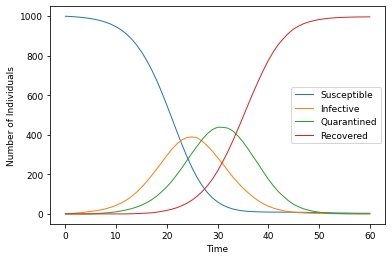

In [10]:
# SIR simulation with p_1 = 1
def SIR_simulation(N, p):
    SS = np.zeros((N, 61))
    II = np.zeros((N, 61))
    QQ = np.zeros((N, 61))
    RR = np.zeros((N, 61))
    for r in range(len(RR)):
        RR[r] = 1000
    Count = np.zeros(N)
    
    for n in range(N):
        t, S, I, Q, R, count = discrete_SIR(GG, p1 = p, tmax = 60)
        for tt in t:
            SS[n, t] = S[t]
            II[n, t] = I[t]
            QQ[n, t] = Q[t]
            RR[n, t] = R[t]
        Count[n] = count
    
    t = range(61)
    S = np.mean(SS, axis=0)
    I = np.mean(II, axis=0)
    Q = np.mean(QQ, axis=0)
    R = np.mean(RR, axis=0)
    count = np.mean(Count)
    
    return np.array(t), np.array(S), np.array(I), np.array(Q), np.array(R), count

t, S, I, Q, R, count = SIR_simulation(N = 100, p = 1)
print(count)
print(max(I))
#print(I)
#print(Q)

plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infective')
plt.plot(t, Q, label='Quarantined')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.legend()
#plt.title('SIR Epidemic Simulation with $p_1 = 1$')
#plt.savefig('SIR with p_1 = 1.svg', format='svg', dpi=1200)
plt.show()

#print(np.where(I < 1)[0][0])

999.0
731.32


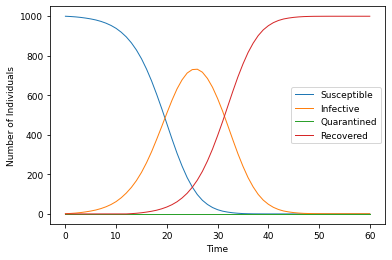

In [11]:
# SIR simulation with p_1 = 0
t, S, I, Q, R, count = SIR_simulation(N = 100, p = 0)
print(count)
print(max(I))

plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infective')
plt.plot(t, Q, label='Quarantined')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.legend()
#plt.title('SIR Epidemic Simulation with $p_1 = 0$')
#plt.savefig('SIR with p_1 = 0.svg', format='svg', dpi=1200)
plt.show()
#print(I)

#print(np.where(I[1:61] < 1.01)[0][0])

# Functions for vaccination strategies

1. no vaccination

In [12]:
## no vaccination
def no_vaccination(N, p):
    SS = np.zeros((N, 201))
    II = np.zeros((N, 201))
    QQ = np.zeros((N, 201))
    Count = np.zeros(N)
    
    for n in range(N):
        t, S, I, Q, R, count = discrete_SIR(GG, p1 = p, tmax = 200)
        for tt in t:
            SS[n, t] = S[t]
            II[n, t] = I[t]
            QQ[n, t] = Q[t]
        Count[n] = count
    
    t = range(201)
    S = np.mean(SS, axis=0)
    I = np.mean(II, axis=0)
    Q = np.mean(QQ, axis=0)
    count = np.mean(Count)
    
    return np.array(t), S[0], np.array(I), np.array(Q), count

#t, S_0, I, Q, count = no_vaccination(N = 100, p = 1)
#print(count)
#print(I)
#print(Q)
#print(S_0)

#plt.plot(t, I, label='Infective')
#plt.plot(t, Q, label='Quarantined')
#plt.xlabel('Time')
#plt.ylabel('Number of Individuals')
#plt.legend()
#plt.title('Discrete SIR Epidemic Simulation')
#plt.show()

2. random vaccination

In [13]:
## random vaccination
def random_vaccination(N, rho, p):
    SS = np.zeros((N, 201))
    II = np.zeros((N, 201))
    QQ = np.zeros((N, 201))
    Count = np.zeros(N)
    kk = int(1000 * rho)
    
    for n in range(N):
        t, S, I, Q, R, count = discrete_SIR(GG, p1 = p, initial_recovereds = random.sample(range(1000), k=kk), tmax = 200)
        for tt in t:
            SS[n, t] = S[t]
            II[n, t] = I[t]
            QQ[n, t] = Q[t]
        Count[n] = count
    
    t = range(201)
    S = np.mean(SS, axis=0)
    I = np.mean(II, axis=0)
    Q = np.mean(QQ, axis=0)
    count = np.mean(Count)
    
    return np.array(t), S[0], np.array(I), np.array(Q), count

#t, S_0, I, Q, count = random_vaccination(N = 100, rho = 0.2, p = 1)
#print(count)
#print(I)
#print(Q)
#print(S_0)

#plt.plot(t, I, label='Infective')
#plt.plot(t, Q, label='Quarantined')
#plt.xlabel('Time')
#plt.ylabel('Number of Individuals')
#plt.legend()
#plt.title('Discrete SIR Epidemic Simulation')
#plt.show()

3. targeted vaccination

In [14]:
## targeted vaccination
def targeted_vaccination(N, rho, p):
    SS = np.zeros((N, 501))
    II = np.zeros((N, 501))
    QQ = np.zeros((N, 501))
    Count = np.zeros(N)
    kk = int(1000 * rho)
    
    degrees = list(GG.degree) # list of (node, number of adjacent edges)
    degrees_sorted = sorted(degrees, key=lambda x: x[1], reverse=True) # sort by decreasing number of edges
    degrees_sorted = [n[0] for n in degrees_sorted] # indices of nodes

    for n in range(N):
        t, S, I, Q, R, count = discrete_SIR(GG, p1 = p, initial_recovereds = degrees_sorted[0:kk], tmax = 500)
        for tt in t:
            SS[n, t] = S[t]
            II[n, t] = I[t]
            QQ[n, t] = Q[t]
        Count[n] = count
    
    t = range(501)
    S = np.mean(SS, axis=0)
    I = np.mean(II, axis=0)
    Q = np.mean(QQ, axis=0)
    count = np.mean(Count)
    
    return np.array(t), S[0], np.array(I), np.array(Q), count

#t, S_0, I, Q, count = targeted_vaccination(N = 1000, rho = 0.2, p = 1)
#print(count)
#print(I)
#print(Q)
#print(kk)
#print(S_0)

#plt.plot(t, I, label='Infective')
#plt.plot(t, Q, label='Quarantined')
#plt.xlabel('Time')
#plt.ylabel('Number of Individuals')
#plt.legend()
#plt.title('Discrete SIR Epidemic Simulation')
#plt.show()

4. acquaintance vaccination

In [15]:
## acquaintance vaccination
def acquaintance_vaccination(N, rho, p):
    SS = np.zeros((N, 201))
    II = np.zeros((N, 201))
    QQ = np.zeros((N, 201))
    Count = np.zeros(N)
    
    kk = int(1000 * rho)
    count0 = 0
    acquaintances = set()
    while count0 < kk:
        u = random.sample(range(1000), k=1)
        for v in np.array(list(GG.neighbors(u[0]))):
            if v not in acquaintances and count0 < kk:
                acquaintances.add(v)
                count0 = count0 + 1

    for n in range(N):
        t, S, I, Q, R, count = discrete_SIR(GG, p1 = p, initial_recovereds = acquaintances, tmax = 200)
        for tt in t:
            SS[n, t] = S[t]
            II[n, t] = I[t]
            QQ[n, t] = Q[t]
        Count[n] = count
    
    t = range(201)
    S = np.mean(SS, axis=0)
    I = np.mean(II, axis=0)
    Q = np.mean(QQ, axis=0)
    count = np.mean(Count)
    
    return np.array(t), S[0], np.array(I), np.array(Q), count

#t, S_0, I, Q, count = acquaintance_vaccination(N = 100, rho = 0.2, p = 1)
#print(count)
#print(length)
#print(I)
#print(Q)
#print(S_0)

#plt.plot(t, I, label='Infective')
#plt.plot(t, Q, label='Quarantined')
#plt.xlabel('Time')
#plt.ylabel('Number of Individuals')
#plt.legend()
#plt.title('Discrete SIR Epidemic Simulation')
#plt.show()

5. ring vaccination

In [16]:
# ring vaccination
def ring_vaccination0(rho0, G, test_transmission = _simple_test_transmission_, test_quarantine = _simple_test_quarantine_, 
                     test_quarantine_neighbors = _simple_test_quarantine_neighbors_, test_detection = _simple_test_detection_,
                     beta = 0.319, p0 = 0.26, p1 = 1,
                     initial_infecteds = None, initial_recovereds = None, 
                     rho = None, tmin = 0, tmax = 1000,
                     return_full_data = False, sim_kwargs = None):
    if rho is not None and initial_infecteds is not None:
        raise EoN.EoNError("cannot define both initial_infecteds and rho")
        
    if initial_infecteds is None:  
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds = random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds = [initial_infecteds]
    
    
    
    N = G.order()
    t = [tmin] ## default: t = 0 as starting time point
    
    if initial_recovereds is not None: ## number of susceptible vertices (at each unit of time)
        S = [N - len(initial_infecteds) - len(initial_recovereds)]
    else:
        S = [N - len(initial_infecteds)]
        
    I = [len(initial_infecteds)] ## number of infected vertices
    Q = [0] ## number of quarantined vertices
    
    if initial_recovereds is not None: ## number of recovered vertices
        R = [len(initial_recovereds)]
    else:
        R = [0]
    
    
            
    susceptibles = set()
    for u in range(N): # for all vertices in the network:
        if initial_recovereds is not None:
            if u not in initial_infecteds and u not in initial_recovereds: # if u is neither intially infected nor vaccinated,
                susceptibles.add(u) # then u is susceptible
        else:
            if u not in initial_infecteds:
                susceptibles.add(u)
            
    infection_time = defaultdict(lambda: np.nan) # point in time when Vertex u is infected
    infectives = set(initial_infecteds) ## infective vertices
    
    quarantineds = set() # quarantines vertices
    qs_s = set() ## quarantined neighbors that are previously susceptible
    qs_i = set() ## quarantined neighbors that are previously infected
    quarantine_time = defaultdict(lambda: np.nan) # point in time when Vertex u starts to quarantine themselves
    
    if initial_recovereds is not None: ## recovered vertices
        recovereds = set(initial_recovereds)
    else:
        recovereds = set()
    
    # ring vaccination:
    count0 = 0 # count of vaccinated individuals
    kk = int(1000 * rho0) # number of vertices to be vaccinated
    
    count = 0 ## number of vertices once infected
    while infectives and t[-1] < tmax:
        new_infectives = set()
        new_susceptibles = set()
        new_quarantineds = set()
        new_qs_i = set()
        new_qs_s = set()
        new_recovereds = set()
        
        
        ## S -> I
        for u in infectives:
            for v in G.neighbors(u):
                if v in susceptibles and v not in new_infectives:
                    if test_transmission(u, v, beta):
                        ## infected vertex:
                        new_infectives.add(v) ## v is infected w.p. beta
                        infection_time[v] = t[-1] # at current time
                        count = count + 1

        susceptibles = susceptibles - new_infectives
        infectives = infectives | new_infectives
        #susceptibles = susceptibles - new_infectives - new_recovereds
        #infectives = infectives | new_infectives
        #recovereds = recovereds | new_recovereds
        
        
        ## I -> Q or S -> Q 
        for u in infectives: 
            # 5 days after Vertex u was infected:
            if t[-1] - infection_time[u] == 5 and test_detection(u, p0) and u not in quarantineds and u not in qs_i and u not in new_quarantineds and u not in new_qs_i: ##!
                ## diagnosed vertex:
                if test_quarantine_neighbors(u, p1):
                    new_quarantineds.add(u) # Vertex u goes into quarantine w.p. p0*p1
                    quarantine_time[u] = t[-1] # at current time
                ## neighbors of diagnosed vertex:
                for v in G.neighbors(u): 
                    if v not in quarantineds and v not in new_quarantineds and v not in qs_s and v not in qs_i and v not in new_qs_s and v not in new_qs_i:
                        if v in susceptibles:
                            # vaccination:
                            if count0 < kk:
                                new_recovereds.add(v)
                                count0 = count0 + 1
                            elif test_quarantine_neighbors(v, p1):
                                new_qs_s.add(v) # (vertices in qs_s will become susceptible again later)
                                quarantine_time[v] = t[-1] 
                        elif v in infectives and test_quarantine_neighbors(v, p1):
                            new_qs_i.add(v) # (vertices in qs_i will recover later)
                            quarantine_time[v] = t[-1]
                    
        infectives = infectives - new_quarantineds - new_qs_i
        susceptibles = susceptibles - new_qs_s - new_recovereds
        quarantineds = quarantineds | new_quarantineds
        qs_i = qs_i | new_qs_i
        qs_s = qs_s | new_qs_s
        recovereds = recovereds | new_recovereds
        
                            
        ## Q -> R or Q -> S
        new_susceptibles_qs = set()
        new_recovereds_q = set()
        new_recovereds_qi = set()
        
        for u in infectives: ## where quarantined vertices were removed 
            if t[-1] - infection_time[u] == 12: ## infected vertex recovers after 12 days ##!
                new_recovereds.add(u)
        for u in quarantineds: 
            if t[-1] - quarantine_time[u] == 7: ## infected vertex recovers after 7 days of quarantine
                new_recovereds_q.add(u)
        for u in qs_s:
            if t[-1] - quarantine_time[u] == 12: ## quarantined neighbor becomes susceptible again after 12 days
                new_susceptibles_qs.add(u) #?
        for u in qs_i:
            if t[-1] - quarantine_time[u] == 12: ## quarantined neighbor recovers after 12 days
                new_recovereds_qi.add(u)
        
        susceptibles = susceptibles | new_susceptibles_qs
        infectives = infectives - new_recovereds
        quarantineds = quarantineds - new_recovereds_q 
        qs_s = qs_s - new_susceptibles_qs
        qs_i = qs_i - new_recovereds_qi
        recovereds = recovereds | new_recovereds | new_recovereds_q | new_recovereds_qi
        
        
        S.append(len(susceptibles))
        I.append(len(infectives))
        Q.append(len(quarantineds) + len(qs_s) + len(qs_i))
        R.append(len(recovereds))
        t.append(t[-1]+1)

        
        
    return np.array(t), np.array(S), np.array(I), np.array(Q), np.array(R), count, count0        
        
    
    
t, S, I, Q, R, count, count0 = ring_vaccination0(rho0 = 0.7, G = GG, tmax = 200)

#print(t)
#print(S+I+R+Q)
#print(S)
#print(I)
#print(Q)
#print(R)
#print(count)
#print(count0)

#plt.plot(t, S, label='Susceptible')
#plt.plot(t, I, label='Infective')
#plt.plot(t, Q, label='Quarantined')
#plt.plot(t, R, label='Recovered')
#plt.xlabel('Time')
#plt.ylabel('Number of Individuals')
#plt.legend()
#plt.title('Discrete SIR Epidemic Simulation')
#plt.show()

In [17]:
## ring vaccination
def ring_vaccination(N, r, p):
    SS = np.zeros((N, 201))
    II = np.zeros((N, 201))
    QQ = np.zeros((N, 201))
    Count = np.zeros(N)
    Count0 = np.zeros(N)
    
    for n in range(N):
        t, S, I, Q, R, count, count0 = ring_vaccination0(rho0 = r, G = GG, p1 = p, tmax = 200)
        for tt in t:
            SS[n, t] = S[t]
            II[n, t] = I[t]
            QQ[n, t] = Q[t]
        Count[n] = count
        Count0[n] = count0
    
    t = range(201)
    S = np.mean(SS, axis=0)
    I = np.mean(II, axis=0)
    Q = np.mean(QQ, axis=0)
    count = np.mean(Count)
    count0 = np.mean(Count0)
    
    return np.array(t), S[0], np.array(I), np.array(Q), count, count0

#t, S_0, I, Q, count, count0 = ring_vaccination(N = 100, r = 0.2, p = 1)
#print(count)
#print(count0)
#print(I)
#print(Q)
#print(S_0)

#plt.plot(t, I, label='Infective')
#plt.plot(t, Q, label='Quarantined')
#plt.xlabel('Time')
#plt.ylabel('Number of Individuals')
#plt.legend()
#plt.title('Discrete SIR Epidemic Simulation')
#plt.show()

# Simulation results:

Function for (1) proportion of population once infected (2) max number of infective individuals (3) time until max infection (4) duration of infection

In [18]:
def results(N, Rho, p, G = GG):
    s0 = [[],[],[],[],[]] # no vaccination
    s1 = [[],[],[],[],[]] # random vaccination
    s2 = [[],[],[],[],[]] # targeted vaccination
    s3 = [[],[],[],[],[]] # acquaintance vaccination
    s4 = [[],[],[],[],[],[]] # ring vaccination
    
    for r in Rho:
        t0, S_00, I0, Q0, count0 = no_vaccination(N, p = p) 
        t1, S_01, I1, Q1, count1 = random_vaccination(N, r, p = p) 
        t2, S_02, I2, Q2, count2 = targeted_vaccination(N, r, p = p)
        t3, S_03, I3, Q3, count3 = acquaintance_vaccination(N, r, p = p)
        t4, S_04, I4, Q4, count4, count_vaccinated = ring_vaccination(N, r, p = p)
        
        # proportion of population once infected
        s0[0].append(count0/1000)
        s1[0].append(count1/1000)
        s2[0].append(count2/1000)
        s3[0].append(count3/1000)
        s4[0].append(count4/1000)
        
        # maximum number of infective individuals
        s0[1].append(max(I0))
        s1[1].append(max(I1))
        s2[1].append(max(I2))
        s3[1].append(max(I3))
        s4[1].append(max(I4))
        
        # time until maximum infection
        s0[2].append(t[np.argmax(I0)])
        s1[2].append(t[np.argmax(I1)])
        s2[2].append(t[np.argmax(I2)])
        s3[2].append(t[np.argmax(I3)])
        s4[2].append(t[np.argmax(I4)])
        
        # duration of infection
        s0[3].append(np.where(I0 < 1)[0][0])
        s1[3].append(np.where(I1 < 1)[0][0])
        s2[3].append(np.where(I2 < 1)[0][0])
        s3[3].append(np.where(I3 < 1)[0][0])
        s4[3].append(np.where(I4 < 1)[0][0])
        
        # number of vaccinated vertices under ring vaccination
        s4[5].append(count_vaccinated)
        
        # proportion of population once infected (relative to size of orginally susceptible population)
        s0[4].append(count0/S_00)
        s1[4].append(count1/S_01)
        s2[4].append(count2/S_02)
        s3[4].append(count3/S_03)
        s4[4].append(count4/S_04)
        
        
    return np.array(s0), np.array(s1), np.array(s2), np.array(s3), np.array(s4)

1. results for network with $r = 0.1$:

(1) proportion of population once infected

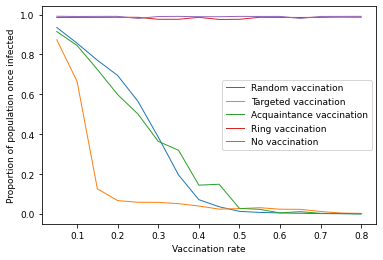

In [19]:
# proportion of population once infected (with rewiring probability 0.1)
R = [x / 100 for x in range(5, 85, 5)] #?
s0, s1, s2, s3, s4 = results(N = 100, Rho = R, p = 1, G = GG)

plt.plot(R, s1[0], label='Random vaccination')
plt.plot(R, s2[0], label='Targeted vaccination')
plt.plot(R, s3[0], label='Acquaintance vaccination')
plt.plot(R, s4[0], label='Ring vaccination')
plt.plot(R, s0[0], label='No vaccination')
plt.xlabel('Vaccination rate') ## ?
plt.ylabel('Proportion of population once infected')
plt.legend()
#plt.title('Proportion of population once infected under different vaccination rates') #?
plt.savefig('PoP r1 p1.svg', format='svg', dpi=1200)
plt.show()

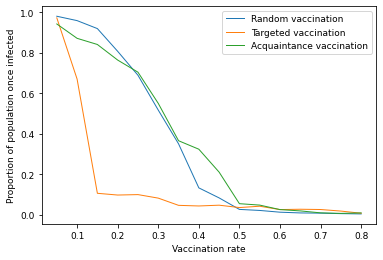

In [308]:
# proportion of population once infected (relative to size of orginally susceptible population)
plt.plot(R, s1[4], label='Random vaccination')
plt.plot(R, s2[4], label='Targeted vaccination')
plt.plot(R, s3[4], label='Acquaintance vaccination')
#plt.plot(R, s0[4], label='No vaccination')
plt.xlabel('Vaccination rate') ## ?
plt.ylabel('Proportion of population once infected')
plt.legend()
#plt.title('Proportion of population once infected under different vaccination rates') #?
plt.savefig('PoP rel.svg', format='svg', dpi=1200)
plt.show()

(2) maximum number of infective individuals

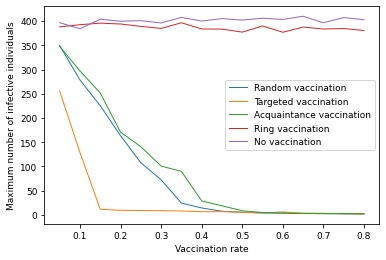

In [194]:
# maximum number of infective individuals (r = 0.1)
plt.plot(R, s1[1], label='Random vaccination')
plt.plot(R, s2[1], label='Targeted vaccination')
plt.plot(R, s3[1], label='Acquaintance vaccination')
plt.plot(R, s4[1], label='Ring vaccination')
plt.plot(R, s0[1], label='No vaccination')
plt.xlabel('Vaccination rate') ## ?
plt.ylabel('Maximum number of infective individuals')
plt.legend()
#plt.title('Maximum number of infective individuals under different vaccination rates') #?
plt.savefig('MoI r1 p1.svg', format='svg', dpi=1200)
plt.show()

(3) time until max infection

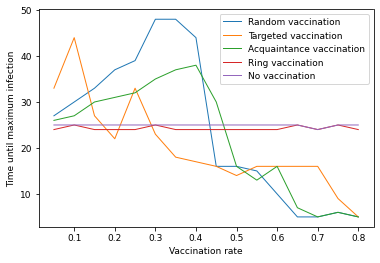

In [179]:
# time until maximum infection (r = 0.1)
plt.plot(R, s1[2], label='Random vaccination')
plt.plot(R, s2[2], label='Targeted vaccination')
plt.plot(R, s3[2], label='Acquaintance vaccination')
plt.plot(R, s4[2], label='Ring vaccination')
plt.plot(R, s0[2], label='No vaccination')
plt.xlabel('Vaccination rate') ## ?
plt.ylabel('Time until maximum infection')
plt.legend()
#plt.title('Time until maximum infection under different vaccination rates') #?
plt.savefig('TMI r1 p1.svg', format='svg', dpi=1200)
plt.show()

(4) duration of infection

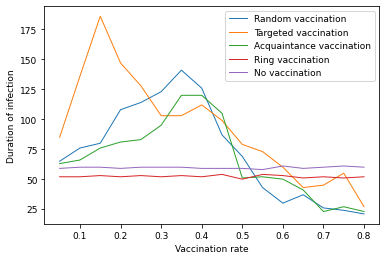

In [180]:
# duration of infection (r = 0.1)
plt.plot(R, s1[3], label='Random vaccination')
plt.plot(R, s2[3], label='Targeted vaccination')
plt.plot(R, s3[3], label='Acquaintance vaccination')
plt.plot(R, s4[3], label='Ring vaccination')
plt.plot(R, s0[3], label='No vaccination')
plt.xlabel('Vaccination rate') ## ?
plt.ylabel('Duration of infection')
plt.legend()
#plt.title('Duration of infection under different vaccination rates') #?
plt.savefig('DoI r1 p1.svg', format='svg', dpi=1200)
plt.show()

2. results for network with $r = 0.5$:

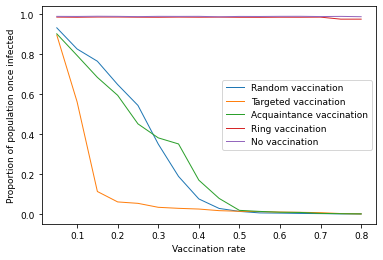

In [219]:
# proportion of population once infected (with rewiring probability 0.5)
R = [x / 100 for x in range(5, 85, 5)] #?
#s0, s1, s2, s3, s4 = results(N = 100, Rho = R, p = 1, G = GG)

plt.plot(R, s1[0], label='Random vaccination')
plt.plot(R, s2[0], label='Targeted vaccination')
plt.plot(R, s3[0], label='Acquaintance vaccination')
plt.plot(R, s4[0], label='Ring vaccination')
plt.plot(R, s0[0], label='No vaccination')
plt.xlabel('Vaccination rate') ## ?
plt.ylabel('Proportion of population once infected')
plt.legend()
#plt.title('Proportion of population once infected under different vaccination rates') #?
plt.savefig('PoP r2 p1.svg', format='svg', dpi=1200)
plt.show()

In [184]:
s2[0] - s3[0]

array([ 0.01836,  0.04576,  0.02844, -0.00614, -0.09529, -0.159  ,
       -0.25575, -0.21112, -0.20447, -0.14928, -0.05126, -0.0504 ,
       -0.00998, -0.00527, -0.00086, -0.00079])

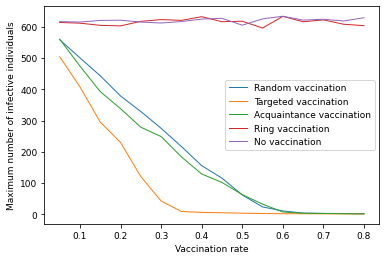

In [222]:
# maximum number of infective individuals (r = 0.5)
s0, s1, s2, s3, s4 = results(N = 100, Rho = R, p = 1, G = GG)

plt.plot(R, s1[1], label='Random vaccination')
plt.plot(R, s2[1], label='Targeted vaccination')
plt.plot(R, s3[1], label='Acquaintance vaccination')
plt.plot(R, s4[1], label='Ring vaccination')
plt.plot(R, s0[1], label='No vaccination')
plt.xlabel('Vaccination rate') ## ?
plt.ylabel('Maximum number of infective individuals')
plt.legend()
#plt.title('Maximum number of infective individuals under different vaccination rates') #?
plt.savefig('MoI r2 p1.svg', format='svg', dpi=1200)
plt.show()

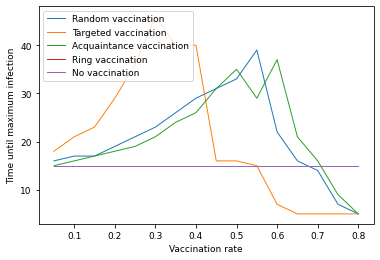

In [186]:
# time until maximum infection (r = 0.5)
plt.plot(R, s1[2], label='Random vaccination')
plt.plot(R, s2[2], label='Targeted vaccination')
plt.plot(R, s3[2], label='Acquaintance vaccination')
plt.plot(R, s4[2], label='Ring vaccination')
plt.plot(R, s0[2], label='No vaccination')
plt.xlabel('Vaccination rate') ## ?
plt.ylabel('Time until maximum infection')
plt.legend()
#plt.title('Time until maximum infection under different vaccination rates') #?
plt.savefig('TMI r2 p1.svg', format='svg', dpi=1200)
plt.show()

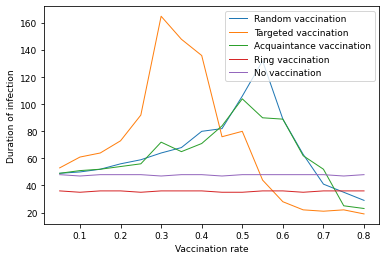

In [187]:
# duration of infection (r = 0.5)
plt.plot(R, s1[3], label='Random vaccination')
plt.plot(R, s2[3], label='Targeted vaccination')
plt.plot(R, s3[3], label='Acquaintance vaccination')
plt.plot(R, s4[3], label='Ring vaccination')
plt.plot(R, s0[3], label='No vaccination')
plt.xlabel('Vaccination rate') ## ?
plt.ylabel('Duration of infection')
plt.legend()
#plt.title('Duration of infection under different vaccination rates') #?
plt.savefig('DoI r2 p1.svg', format='svg', dpi=1200)
plt.show()

3. number of vaccinated vertices under ring vaccination:

In [221]:
# number of vaccinated vertices under ring vaccination
count_ring1 = s4[5] # r = 0.1

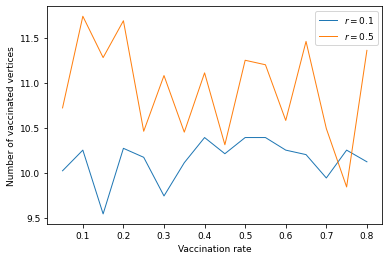

In [224]:
count_ring2 = s4[5] # r = 0.5
plt.plot(R, count_ring1, label='$r = 0.1$')
plt.plot(R, count_ring2, label='$r = 0.5$')
plt.xlabel('Vaccination rate') ## ?
plt.ylabel('Number of vaccinated vertices')
plt.legend()
#plt.title('Number of vaccinated vertices under ring vaccination') #?
plt.savefig('NoV.svg', format='svg', dpi=1200)
plt.show()

4. Effectiveness of targeted vaccination, when $p_1$ ranges from 0 to 1:

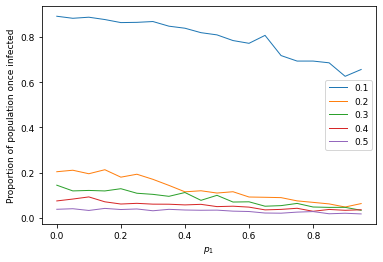

In [276]:
# targeted vaccination given different p_1
P1 = [x / 100 for x in range(0, 100, 5)] # p_1
Rho = [0.1, 0.2, 0.3, 0.4, 0.5] # vaccination rates
Proportion = np.zeros((len(Rho), len(P1)))
Maximum = np.zeros((len(Rho), len(P1)))
TimetoMax = np.zeros((len(Rho), len(P1)))
Duration = np.zeros((len(Rho), len(P1)))
for i in range(len(Rho)):
    for j in range(len(P1)):
        t, S_0, I, Q, count = targeted_vaccination(N = 100, rho = Rho[i], p = P1[j])
        Proportion[i][j] = count/1000
        Maximum[i][j] = max(I)
        TimetoMax[i][j] = t[np.argmax(I)]
        Duration[i][j] = np.where(I < 1.01)[0][1]
        
plt.plot(P1, Proportion[0], label='0.1') #*
plt.plot(P1, Proportion[1], label='0.2')
plt.plot(P1, Proportion[2], label='0.3')
plt.plot(P1, Proportion[3], label='0.4')
plt.plot(P1, Proportion[4], label='0.5')
plt.xlabel('$p_1$') ## ?
plt.ylabel('Proportion of population once infected')
plt.legend()
#plt.title('Proportion of population once infected under targeted vaccination, given different values of $p_1$') #?
plt.savefig('PoP p_1.svg', format='svg', dpi=1200)
plt.show()

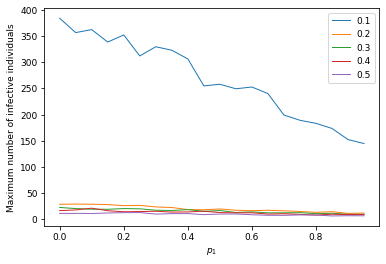

In [277]:
plt.plot(P1, Maximum[0], label='0.1') #*
plt.plot(P1, Maximum[1], label='0.2')
plt.plot(P1, Maximum[2], label='0.3')
plt.plot(P1, Maximum[3], label='0.4')
plt.plot(P1, Maximum[4], label='0.5')
plt.xlabel('$p_1$') ## ?
plt.ylabel('Maximum number of infective individuals')
plt.legend()
#plt.title('Maximum number of infective individuals under targeted vaccination, given different values of $p_1$') #?
plt.savefig('MoI p_1.svg', format='svg', dpi=1200)
plt.show()

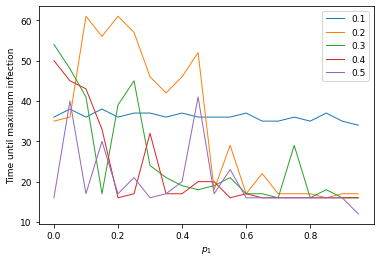

In [278]:
plt.plot(P1, TimetoMax[0], label='0.1') #*
plt.plot(P1, TimetoMax[1], label='0.2')
plt.plot(P1, TimetoMax[2], label='0.3')
plt.plot(P1, TimetoMax[3], label='0.4')
plt.plot(P1, TimetoMax[4], label='0.5')
plt.xlabel('$p_1$') ## ?
plt.ylabel('Time until maximum infection')
plt.legend()
#plt.title('Time until maximum infection under targeted vaccination, given different values of $p_1$') #?
plt.savefig('TMI p_1.svg', format='svg', dpi=1200)
plt.show()

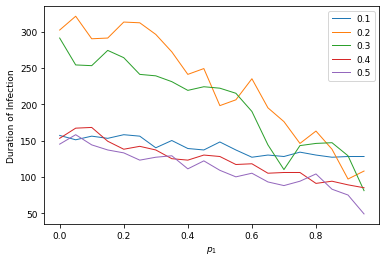

In [279]:
plt.plot(P1, Duration[0], label='0.1') #*
plt.plot(P1, Duration[1], label='0.2')
plt.plot(P1, Duration[2], label='0.3')
plt.plot(P1, Duration[3], label='0.4')
plt.plot(P1, Duration[4], label='0.5')
plt.xlabel('$p_1$') ## ?
plt.ylabel('Duration of Infection')
plt.legend()
#plt.title('Duration of Infection under targeted vaccination, given different values of $p_1$') #?
plt.savefig('DoI p_1.svg', format='svg', dpi=1200)
plt.show()